# Cohort 6 Screening

## Task 1

I'm going to work on the first task in this cohort, as the papers featured as references as well as the problem itself seemed really interesting to me.

### Task
To make a multiplier, for this we design the input of two positive integers to a function and this function will process a quantum algorithm that makes the multiplier (see Draper adder) and returns the result in an integer.

### Contents

I start with short preliminaries where I introduce some helpers. Then I will build solution based on the multiplication circuit proposed by Ruiz-Perez et al. in [1]. Finally, I'll test and benchmark the solution. An alternative approach may be found in [3].

**References:**

[1] Ruiz-Perez et al., Quantum arithmetic with the Quantum Fourier Transform, 2017. ([arXiv:1411.5949](https://arxiv.org/pdf/1411.5949.pdf))

[2] T. G. Draper, Addition on a quantum computer, 2000. ([ arXiv:quant-ph/0008033v1](https://arxiv.org/pdf/quant-ph/0008033.pdf))

[3] Muñoz-Coreas et al., T-count Optimized Design of Quantum Integer Multiplication, 2017. ([ 	arXiv:1706.05113](https://arxiv.org/pdf/1706.05113.pdf))

### Preliminaries
Below I define some useful helpers and import all dependencies, so as not to disrupt the process of the solution design afterwards.

#### Imports

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, assemble
from qiskit.circuit.library import QFT

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import time

aer_simulator = Aer.get_backend('aer_simulator')
unitary_simulator = Aer.get_backend('unitary_simulator')

De/Encoding helpers.

In [2]:
def dec_to_bin(t):
    """Return integer t in a form of binary string."""
    return "{0:b}".format(t)

def dec_to_bin_padded(t, n):
    """Return integer t in a form of binary string ensuring that it has exactly n digits."""
    return "{0:b}".format(t).zfill(n)

def bin_to_dec(t):
    """Parse integer t encoded in binary string."""
    return int(t, 2)

The circuit is a concatenation of the following registers:
* `n`-bit `a` encoding first operand
* `n`-bit `b` encoding second operand
* `2n`-bit `result` encoding the result of multiplication (when te circuit is ready)

In [3]:
class QuantumMultiplication:
    """Class used as a struct holding references to all logical parts of the circuit."""

    def __init__(self, n):
        self.n = n
        self.number_b = QuantumRegister(n, 'b')
        self.number_a = QuantumRegister(n, 'a')
        self.result = QuantumRegister(2*n, 'r')
        self.measurement = ClassicalRegister(2*n, 'c')
        self.circuit = QuantumCircuit(self.number_b, self.number_a, self.result, self.measurement)

### Implementation

First block of the composition is the preparation of the state, so encoding numbers on registers `a` and `b` and preparing state $\left|\phi(0)\right\rangle$ on the `result` register.

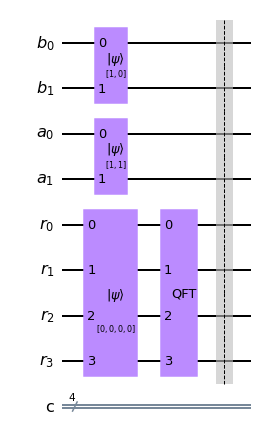

In [4]:
n = 2
a = 2
b = 3

qm = QuantumMultiplication(n)

qm.circuit.initialize(dec_to_bin_padded(a, n), qm.number_b)
qm.circuit.initialize(dec_to_bin_padded(b, n), qm.number_a)
qm.circuit.initialize('0'*(2*n), qm.result)

qm.circuit.compose(QFT(num_qubits=2*qm.n, do_swaps=False, inverse=False), qm.result, inplace=True)
qm.circuit.barrier()

        
qm.circuit.draw(output='mpl')    

Main block of the circuit is $2^i\Sigma$, being a controlled Draper adder (see [2]). Such a block consists of controlled phase rotation gates $R_l$ (see eq. (15) in [1]), where $l = i+j+s-2n$. Note that we skip $R_l$ for $l \leq 0$, as these are rotations of multiples of $2\pi$ (and wouldn't change anything). Below I construct $2^0\Sigma$ on multiplication of 3-qbit numbers.

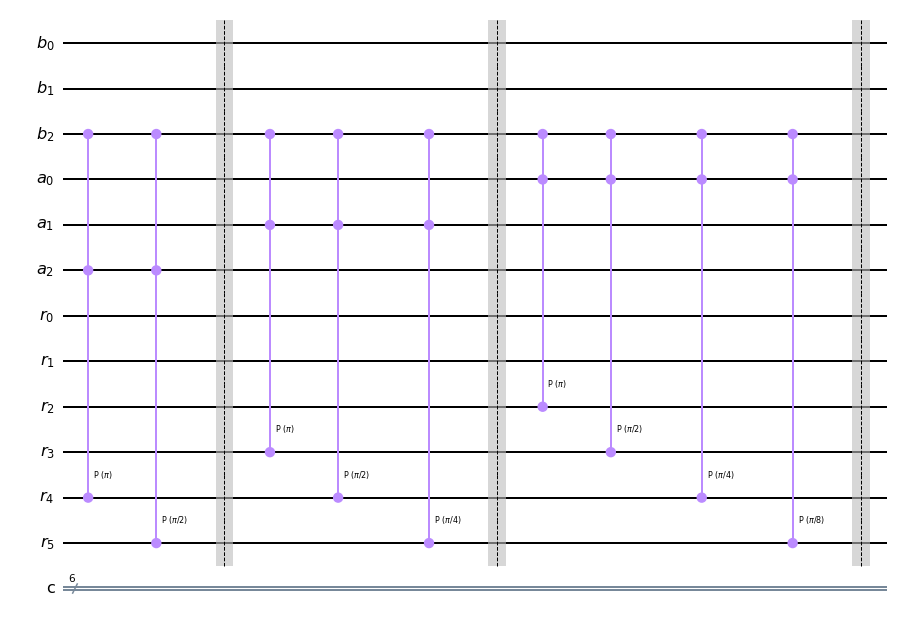

In [5]:
n = 3
j = 1

qm = QuantumMultiplication(n)

for i in range(1, n+1):
    for s in range(1,2*n+1):
        l = i + j + s - 2*n
        if l <= 0:
            continue

        lam = (2 * np.pi) / (2**l)
        qm.circuit.mcp(lam, [qm.number_a[n-i], qm.number_b[n-j]], qm.result[s-1])
    qm.circuit.barrier()
        
qm.circuit.draw(output='mpl')

Now composition of whole multiplier seems easy. If we compose all adders, we need to finalize cirucit with `IQFT` and measurements of result qbits.

In [6]:
def build_multiplication_circuit(a, b):
    n = max(len(dec_to_bin(x)) for x in (a,b))
    
    qm = QuantumMultiplication(n)
    
    # Initialize - initialize qbits and prepare QFT(0)
    qm.circuit.initialize("{0:b}".format(a).zfill(n), qm.number_b)
    qm.circuit.initialize("{0:b}".format(b).zfill(n), qm.number_a)
    qm.circuit.initialize('0'*(2*n), qm.result)

    qm.circuit.compose(QFT(num_qubits=2*n, do_swaps=False, inverse=False), qm.result, inplace=True)
    qm.circuit.barrier()
    
    # Compose adders controlled by qbits of B
    for j in range(1, n+1):
        for i in range(1, n+1):
            for s in range(1,2*n+1):
                l = i + j + s - 2*n
                if l <= 0:
                    continue

                lam = (2 * np.pi) / (2**l)
                qm.circuit.mcp(lam, [qm.number_a[n-i], qm.number_b[n-j]], qm.result[s-1])
            qm.circuit.barrier()
    
    # Finialize - add inverse QFT and measurements
    qm.circuit.compose(QFT(2*qm.n,  do_swaps=False, inverse=True), qm.result, inplace=True)
    qm.circuit.measure(qm.result, qm.measurement)
    
    return qm.circuit

As for the sake of the convenience I used `.initialize` and `QFT()` Aer won't run my circuit without transpilation. Fortunately, both are easy to transpile, even "manually".

In [7]:
EXPERIMENT_SHOTS = 100

def run_experiment(circuit):
    """
    Run experiment with circuit. Number of runs is conrolled by global const.
    Returned value is a dictionary with keys being parsed integers measured on result register
    and values being normalised frequencies (0.0-1.0).
    """
    transpiled = transpile(circuit, backend=unitary_simulator)
    qobj = assemble(transpiled)
    result = aer_simulator.run(qobj, shots=EXPERIMENT_SHOTS).result()
    counts = result.get_counts()
    transformed_counts = {bin_to_dec(k): (v * 1.0) / EXPERIMENT_SHOTS for (k,v) in counts.items()}
    return transformed_counts

In [8]:
def multiplier(number_1, number_2):
    """
        number_1 : integer positive value that is the first parameter to the multiplier function,
        number_2 : integer positive value that is the second parameter to the multiplier function.
        Return the positive integer value of the multiplication between number_1 and number_2
    """
    
    circuit = build_multiplication_circuit(number_1, number_2)
    normalised_measurements = run_experiment(circuit)
    result = max(normalised_measurements, key=normalised_measurements.get)

    return result

a = 2
b = 3

print(multiplier(a, b))

6


The function above is the function as described in the task. As it works at first glance, I may proceed with some benchmarks. To this end I define similar function returning `accuracy`, being the normalised frequency of correctly obtained result (i.e. `1.0` means that all simulations resulted with correct number)

In [9]:
def benchmark_multiplier(number_1, number_2):
    circuit = build_multiplication_circuit(number_1, number_2)
    unified_measurements = run_experiment(circuit)

    expected_value = number_1 * number_2
    accuracy = unified_measurements.get(expected_value) or 0

    return accuracy

a = 2
b = 3

print(benchmark_multiplier(a, b))

1.0


If we assume that number of bits of multiplied numbers $n$ is relatively small, traversing all $N^2, N=2^n$ pairs $(a,b)$ is a reasonable goal. Finding minimum in array of results let us detect if there were any errors (any freq. other than `1.0` indicates error). The heatmap will serve as a convenient form of visualization.

Min accuracy: 1.0


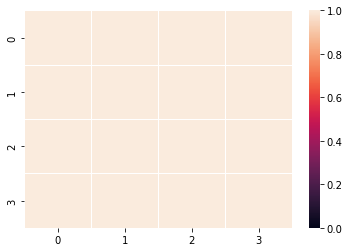

In [10]:
def benchmark_accuracy(bits_number):
    max_value = 2**bits_number - 1
    possible_operands = list(range(max_value+1))
    
    results = np.array(list(list((benchmark_multiplier(a, b) for a in possible_operands)) for b in possible_operands), dtype=float)
    return results

def draw_heatmap(array):
    sns.heatmap(array, linewidth=0.5, vmin=0.0, vmax=1.0)
    return plt.show()

results = benchmark_accuracy(2)
print("Min accuracy: {}".format(np.amin(results)))

draw_heatmap(results)

Min accuracy: 1.0


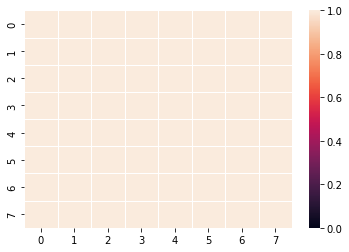

In [11]:
results = benchmark_accuracy(3)
print("Min accuracy: {}".format(np.amin(results)))

draw_heatmap(results)

Min accuracy: 1.0


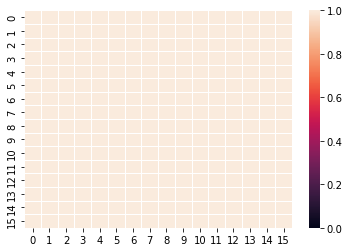

In [12]:
results = benchmark_accuracy(4)
print("Min accuracy: {}".format(np.amin(results)))

draw_heatmap(results)

Coloring whole space takes longer and longer. Signle multiplication lasts longer, but the main factor is number of multiplications performed. Complexity of single multiplication is $O(n^3)$, while complexity of performing all possible multiplications is $O((2^n)^2)$.

The other way of benchmarking, which allow to benchmark larger values of $n$ (with upper bound of 6, due to simulation limitations) is to draw some random samples for given $n$.

In [13]:
REPEATS = 10

def benchmark_for(n, accuracies, times):
    accuracies.append([])
    times.append([])
    
    for r in range(REPEATS):
        a, b = np.random.randint(2**n, size=2)
        
        start = time.time()
        result = benchmark_multiplier(a,b)
        end = time.time()
        
        accuracies[-1].append(result)
        times[-1].append(end-start)

In [14]:
n_values = range(2, 7)
accuracy_samples = []
time_samples = []

for n in n_values:
    benchmark_for(n, accuracy_samples, time_samples)
    log_row = "n = {}\t accuracy: {} +- {}; time: {:.3f} +- {:.3f}s".format(n, np.mean(accuracy_samples[-1]), np.std(accuracy_samples[-1]), np.mean(time_samples[-1]), np.std(time_samples[-1]))
    print(log_row)

n = 2	 accuracy: 1.0 +- 0.0; time: 0.112 +- 0.033s
n = 3	 accuracy: 1.0 +- 0.0; time: 0.215 +- 0.051s
n = 4	 accuracy: 1.0 +- 0.0; time: 0.377 +- 0.068s
n = 5	 accuracy: 1.0 +- 0.0; time: 0.696 +- 0.725s
n = 6	 accuracy: 1.0 +- 0.0; time: 25.166 +- 15.054s


### Conclusions

Referenced papers give examples of robust implementations of arithmetic using `QFT`. This shows the potential that phase encoding brings.